# SHapely Additive exPlanations 

## Definition and intuition

SHAP is a method that unifies many of the current machine learning explanation methods. It is a linear feature attribution methods. This means that the explanation model that approximates the actual model attributes effect linearly to the features. It uses results from coalitional game theory to adapt other methods such as LIME, DeepLift etc... And find the feature attribution method that guarantees the shapely values in the linear attribution method.    
The Shapley value in game theory represents the attribution method that ensures fairness.  

In this notebook we will dive into Kernel SHAP also referred to in [the paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)  as LIME + SHAP. It uses LIME as a theory and fixes its parameters to ensures the necessary properties that give Shapley values

## Interpretability with kernel SHAP

### Characteristics 
* Model-agnostic : This method is blind to the model we use 
* Local : we explain the decision for a single sample

## Importations
The implementation of SHAP used in this notebook is from the implementation of one of the creators ([see on GitHub](https://github.com/slundberg/shap))

In [1]:
# specific importations to SHAP
import shap

# Importing black box models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# import datasets
from mlinutils.datasets import Bikes, Loans

import mlinutils.sanity as san
import mlinutils.shap_utils as shapu

In [2]:
#  make plot outputs appear and be stored within the notebook
%matplotlib inline
shap.initjs()

## The datasets we're using 

### Data description
The full description of the Datasets that are used in this entire collection of notebooks is available separately 
* Bike sharing: Daily counts of bike rentals from bike sharing along with weather and seasonal information. <a href="bike_sharing_dataset.ipynb">See bike sharing dataset exploration</a>.
* Lending club: information on users and wether or not they default on their payments from a peer to peer lending online service <a href="lending_club_dataset">see lending club dataset exploration</a> 

### Data importation 

In [3]:
# Importing bike sharing
bikes = Bikes()
bk_X_train, bk_X_test, bk_y_train, bk_y_test = bikes.load()

### Data preview
Take a peak into the data we'll be using !

In [4]:
bikes.preview()

This dataset contains 17379 instances with 14 attributes


,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
10071,spring,1.0,February,5pm-8pm,0.0,Wednesday,1.0,Medium,16.40,20.455,87.0,11.0014,253.0,424.0
7791,winter,0.0,November,6am-10am,0.0,Saturday,0.0,Medium,12.30,15.910,75.0,6.0032,10.0,329.0
4626,fall,0.0,July,11am-4pm,0.0,Saturday,0.0,Good,31.16,34.090,45.0,19.0012,425.0,196.0
7113,winter,0.0,October,9pm-5am,0.0,Saturday,0.0,Bad,11.48,12.880,87.0,19.9995,19.0,301.0
6258,winter,0.0,September,6am-10am,0.0,Friday,1.0,Bad,25.42,27.275,94.0,8.9981,317.0,265.0


## Application

### Plan
In order to see lime in action we will use it for different tasks, and we will use two black box models to explain : Random Forests and Multi Layer Perceptron.
* <a href=#reg>Regression with Bike Sharing</a>
    * <a href=#regrf>Random Forests SHAP explanation</a>
        * <a href=#regrfm> Model creation and sanity checks</a>
        * <a href=#regrfe> Explanation </a>
    * <a href=#regmlp>MLP SHAP explanation</a>
        * <a href=#regmlpm> Model creation and sanity checks </a>
        * <a href=#regmlpe> Explanation </a>
* <a href=#clf>Classification with Lending Club</a>
    * <a href=#clfrf>Random Forests SHAP explanation</a>
        * <a href=#clfrfm> Model creation and sanity checks </a>
        * <a href=#clfrfe> Explanation </a>
    * <a href=#clfmlp>MLP SHAP explanation</a>
        * <a href=#clfmlpm> Model creation and sanity checks </a>
        * <a href=#clfmlpe> Explanation </a>
* <a href=#conc>Conclusion</a>

### Regression with Bike Sharing <a name=reg>

#### Random Forests SHAP explanation <a name=regrf>

##### Model creation and sanity checks <a name=regrfm>

In [5]:
bike_rf = RandomForestRegressor(n_estimators=300, max_depth=12, max_features="sqrt", random_state=22)
bike_rf = bike_rf.fit(bk_X_train, bk_y_train)

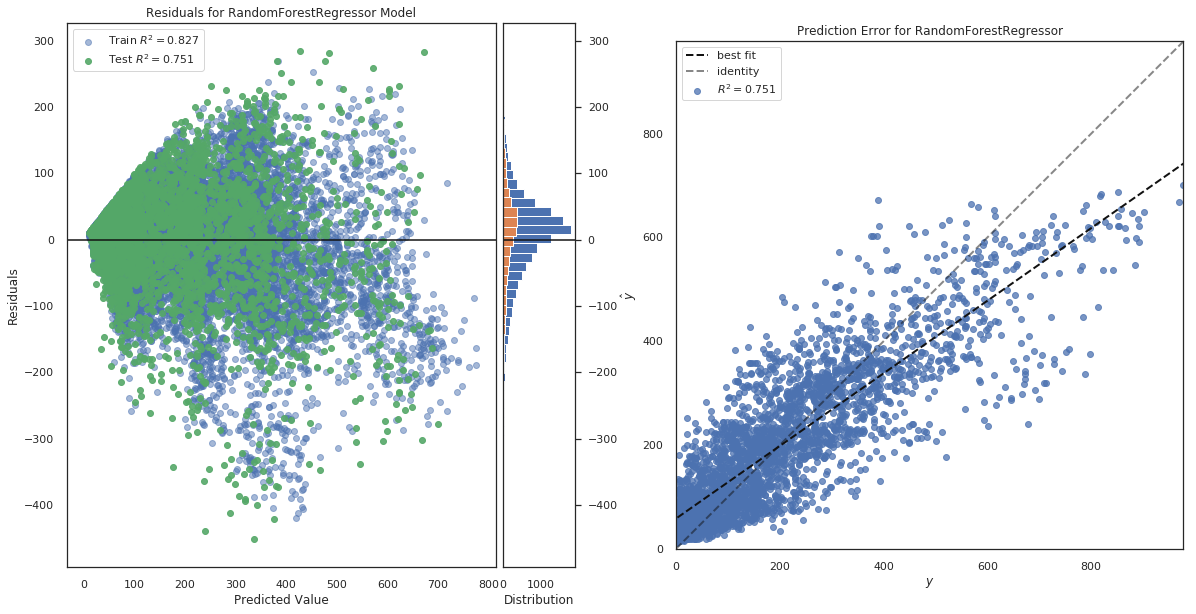

In [6]:
san.regression_sanity_check(bike_rf, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

##### Explanation <a name=regrfe>

**What we feed kernel SHAP**

* The background data:  Is either the training set r the centroids of a clustering in order for the explainer to have a gist of what the data looks like 

> **Shap and groups**: The internal structure of SHAP uses feature groups in order to remain coherent. Here for example we use two datasets with categorical features. We proceed to one hot encode them using pandas get dummies. The problem is when we explain the data as is the samples that will be generated won't have that understanding of what is real. Let's take the bike sharing dataset for instance we have the dummified category season represented in the four features : fall, winter, spring and summer. If we don't use that variables groups and group names in the background data we will have some instances where it's fall and spring at the same time!

In [7]:
bikes_background = shapu.build_background_data(bikes, bk_X_train, 10)
bikes_rf_kernel_explainer = shap.KernelExplainer(bike_rf.predict, bikes_background)

In [8]:
sample_bike = bk_X_test.iloc[55]

## recovers the original format just for reading convenience
bikes.data.iloc[[sample_bike.name],:]

,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
16133,winter,1.0,November,9pm-5am,0.0,Friday,1.0,Good,13.12,16.665,81.0,6.0032,162.0,678.0


In [9]:
sample_bike_rf_shap = bikes_rf_kernel_explainer.shap_values(sample_bike)

In [10]:
shap.force_plot(base_value=bikes_rf_kernel_explainer.expected_value, 
                shap_values=sample_bike_rf_shap, 
                feature_names=shapu.make_readable_features(bikes, sample_bike, bikes_background.group_names),
                out_names=["Bikes count"])

In [11]:
print("Random forest prediction is:", bike_rf.predict(sample_bike.values.reshape(1, -1)))

Random forest prediction is: [69.4723101]


**What SHAP gives us**

This representation is called a force plot, it draws the analogy that features are forces that push the decision to be higher (pink) or lower (blue) than the base value. The base values is computed from the background data that we talked about

> The trend throughout the time (`days_since_2001` and `year`) has a positive influence on bike rentals, but the hour of the day, temperature and humidity impact the count negatively (we've seen this particular explanation for LIME for the same model)

### Bike sharing rentals with Multi-Layer Perceptron <a name=regmlp>

Let's try another type of machine learning algorithm. We use a Neural Networl model most know as Multi-layer Perceptron (MLP).
It is worth noting that MLP fitting is high sensitive to feature scaling, so we scale numerical data to [0, 1] before feedind data to the algorithm.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

In [13]:
bike_mlp = MLPRegressor(hidden_layer_sizes=(25, 75, 100), 
                        alpha=10, 
                        learning_rate_init=0.01, 
                        max_iter=6000, 
                        early_stopping=True, 
                        random_state=22)

bikes_pipeline_mlp = make_pipeline(MinMaxScaler(), bike_mlp)
bikes_pipeline_mlp.fit(bk_X_train, bk_y_train)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('mlpregressor', MLPRegressor(activation='relu', alpha=10, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(25, 75, 100), learning_rate='constant',
       learnin...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

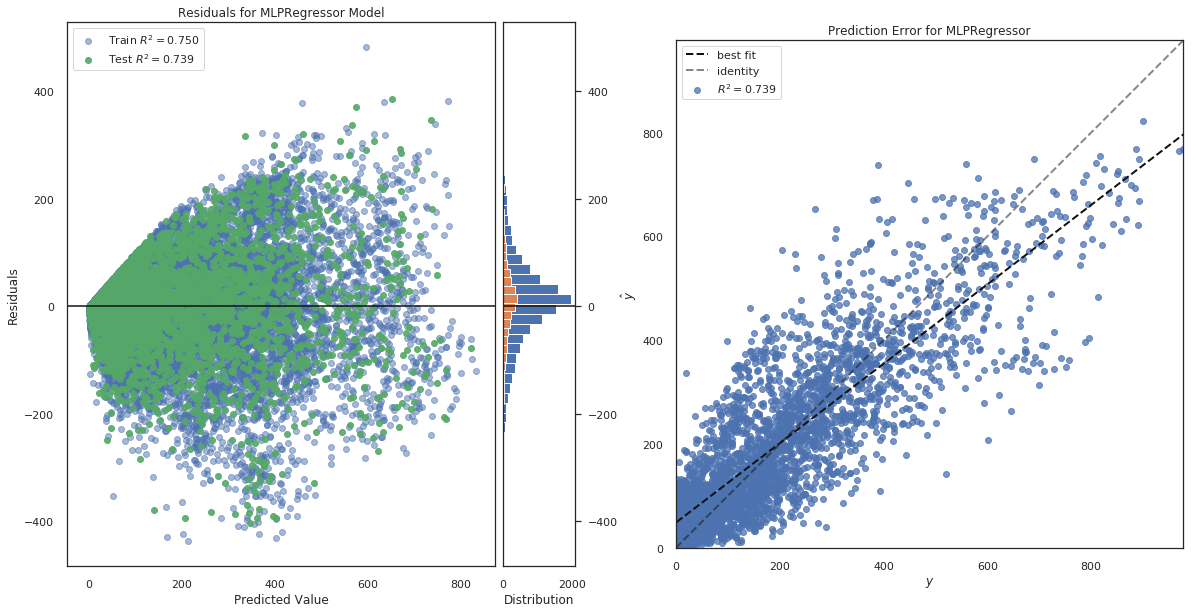

In [14]:
san.regression_sanity_check(bikes_pipeline_mlp, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

##### Explanation <a name=regmlpe>

In [15]:
bikes_mlp_kernel_explainer = shap.KernelExplainer(bikes_pipeline_mlp.predict, bikes_background)

In [16]:
sample_bike_mlp_shap = bikes_mlp_kernel_explainer.shap_values(sample_bike)

In [17]:
shap.force_plot(base_value=bikes_mlp_kernel_explainer.expected_value, 
                shap_values=sample_bike_mlp_shap, 
                feature_names=shapu.make_readable_features(bikes, sample_bike, bikes_background.group_names),
                out_names=["Bikes count"])

In [18]:
print("MLP prediction is:", bikes_pipeline_mlp.predict(sample_bike.values.reshape(1, -1)))

MLP prediction is: [42.14760606]


> This model seems to take into account the upwards trend in bike sharing trough the days and the temperature, again we've seen similar things in LIME for the same model

### Classification with Lending Club <a name=clf>

In [19]:
# Importing lending club data set
loans = Loans()
ln_X_train, ln_X_test, ln_y_train, ln_y_test = loans.load()

In [20]:
loans.preview()

This dataset contains 98339 instances with 19 attributes


,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
58794,28000.0,15.61,675.12,5.0,10.0,MORTGAGE,71000.0,Source Verified,debt_consolidation,16.45,0.0,0.0,11.0,11344.0,45.4,1.0,1.0,170.976817,1
95130,18225.0,13.11,615.04,6.0,10.0,MORTGAGE,140000.0,Verified,small_business,33.27,0.0,0.0,17.0,47173.0,58.1,1.0,1.0,351.021582,0
44694,6675.0,16.29,235.63,4.0,9.0,RENT,42000.0,Source Verified,debt_consolidation,18.45,1.0,1.0,11.0,5377.0,30.4,1.0,1.0,105.989856,0
1491,18000.0,15.61,434.01,5.0,5.0,RENT,40000.0,Verified,debt_consolidation,12.30,0.0,0.0,9.0,9766.0,37.3,1.0,1.0,212.045422,1
21726,5000.0,6.62,153.52,7.0,4.0,OWN,100000.0,Not Verified,credit_card,9.15,0.0,2.0,12.0,37.0,0.1,1.0,1.0,189.014148,0


#### Random Forests SHAP explanation <a name=clfrf>

##### Model creation and sanity checks <a name=clfrfm>

In [21]:
# Model creation 
loan_rf =  RandomForestClassifier(n_estimators=100, max_depth=12, max_features="sqrt", random_state=22) 
loan_rf = loan_rf.fit(ln_X_train, ln_y_train)

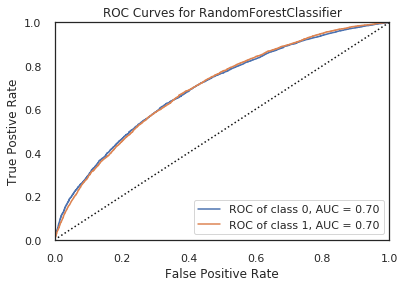

In [22]:
san.classification_sanity_check(loan_rf, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

##### Explanation <a name=clfrfe>

In [23]:
loans_background = shapu.build_background_data(loans, ln_X_train, 10)
loans_rf_kernel_explainer = shap.KernelExplainer(loan_rf.predict_proba, loans_background)

In [24]:
sample_loans = ln_X_test.iloc[3]

## recovers the original format just for reading convenience
loans.data.iloc[[sample_loans.name], :]

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
41230,7000.0,15.61,244.76,4.0,1.0,RENT,56550.0,Source Verified,debt_consolidation,23.6,1.0,1.0,10.0,2193.0,17.8,1.0,1.0,53.980575,1


In [25]:
sample_loans_rf_shap = loans_rf_kernel_explainer.shap_values(sample_loans)

In [26]:
shap.force_plot(base_value=loans_rf_kernel_explainer.expected_value[1], 
                shap_values=sample_loans_rf_shap[1], 
                feature_names=shapu.make_readable_features(loans, sample_loans, loans_background.group_names),
                out_names=["Default risk"]
)

> Here we can plot the explanation for both classes (good and bad loan status)   
All the values contribute negatively which is seeing their values is coherent with the data and previous explanation methods

In [27]:
print("Random forest prediction for 'Bad loan' class is:", loan_rf.predict_proba(sample_loans.values.reshape(1, -1))[0][1])

Random forest prediction for 'Bad loan' class is: 0.3018655568925749


#### MLP SHAP explanation <a name=clfmlp>

##### Model creation and sanity checks <a name=clfmlpm>

In [28]:
loans_mlp = MLPClassifier(hidden_layer_sizes=(50), 
                          learning_rate_init=0.05,
                          max_iter=10000, 
                          early_stopping=True, 
                          random_state=22)

loans_pipeline_mlp = make_pipeline(MinMaxScaler(), loans_mlp)
loans_pipeline_mlp.fit(ln_X_train, ln_y_train)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('mlpclassifier', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rat...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

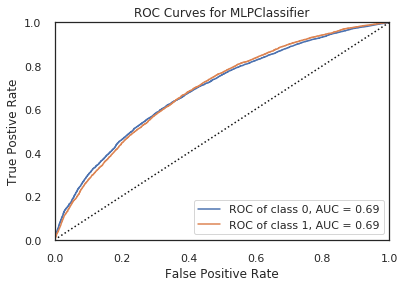

In [29]:
san.classification_sanity_check(loans_pipeline_mlp, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

##### Explanation <a name=clfmlpe>

In [30]:
load_mlp_kernel_explainer = shap.KernelExplainer(loans_pipeline_mlp.predict_proba, loans_background)

In [31]:
sample_loans_mlp_shap = load_mlp_kernel_explainer.shap_values(sample_loans)

In [32]:
shap.force_plot(base_value=load_mlp_kernel_explainer.expected_value[1], 
                shap_values=sample_loans_mlp_shap[1], 
                feature_names=shapu.make_readable_features(loans, sample_loans, loans_background.group_names),
                out_names=["Default risk"]
)

In [33]:
print("MLP prediction for 'Bad loan' class is:", loans_pipeline_mlp.predict_proba(sample_loans.values.reshape(1, -1))[0][1])

MLP prediction for 'Bad loan' class is: 0.3483267442389711


### Conclusion <a name=conc>

Kernel shap is an adaptation of LIME that approximates the SHAP values. This method is much more stable than LIME as it doesn't need much hyperparameter tuning.